In [1]:
from src import bootstrap, trainer, data, models, util
from src.preprocess.adni import encode_adni, process_adni
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, log_loss

import numpy as np

from sklearn.calibration import calibration_curve
import matplotlib.lines as line
import matplotlib.pyplot as plt


/opt/homebrew/Caskroom/miniconda/base/envs/cpr/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/envs/cpr/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/envs/cpr/l

In [2]:
# Change this suffix name if you want to retrain the model, otherwise it will load the saved model
suffix = "split"

exp_name = f"ADNI_{suffix}"

In [3]:
bs_name = "ADNI_2"
feature_cols = ["CDRSB_med", "CDRSB_high", "hippocampus_low",
 "hippocampus_avg", "hippocampus_high"]
time_col = "t"
target_col = "a_n"
identifier_col = "RID"
dataset = "adni"

input_size = len(feature_cols) + 2
context_size = len(feature_cols) + 1

## Load data

In [4]:
train_r, val_r, test_r = bootstrap.load_split(dataset=dataset)
train = encode_adni(train_r)
val = encode_adni(val_r)
test = encode_adni(test_r)

ds_train = data.Context_df_dataset(train, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col,
                                    max_length=train.t.max() + 1)
ds_val = data.Context_df_dataset(val, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col,
                                    max_length=train.t.max() + 1)
ds_test = data.Context_df_dataset(test, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col,
                                    max_length=test.t.max() + 1)

loader_train = DataLoader(ds_train, shuffle=True, batch_size=64)
loader_val = DataLoader(ds_val, shuffle=True, batch_size=64)
loader_test = DataLoader(ds_test, shuffle=False, batch_size=1)

ds_train_v = data.Vanilla_df_dataset(train, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col, 
                                     action_col="a", max_length=train.t.max() + 1)
ds_val_v = data.Vanilla_df_dataset(val, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col, 
                                     action_col="a", max_length=train.t.max() + 1)
ds_test_v = data.Vanilla_df_dataset(test, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col, 
                                     action_col="a", max_length=train.t.max() + 1)

loader_train_v = DataLoader(ds_train_v, shuffle=True, batch_size=64)
loader_val_v = DataLoader(ds_val_v, shuffle=True, batch_size=64)
loader_test_v = DataLoader(ds_test_v, shuffle=False, batch_size=1)

full_df = pd.concat([train, val, test]).reset_index(drop=True)
ds_all = data.Context_df_dataset(full_df, feature_cols=feature_cols, target_col=target_col, identifier_col=identifier_col, 
                                 max_length=full_df.t.max() + 1)
loader_all = DataLoader(ds_all, shuffle=False, batch_size=1) 

## Train model

In [5]:
for rnn_type in ["LSTM", "RNN"]:
    trainer.train_contextual(exp_name=exp_name, context_size=7, input_size=6, train_loader=loader_train, 
                            val_loader=loader_val, lr=5e-4, lambdas=[0.1, 0.01, 0.001, 0.0001])

for rnn_type in ["LSTM", "RNN"]:
    trainer.train_vanilla(exp_name=exp_name, input_size=7, train_loader=loader_train_v, 
                            val_loader=loader_val_v, lr=1e-4)


Run context_LSTM_16_0.1 already exists, skipping.
Run context_LSTM_16_0.01 already exists, skipping.
Run context_LSTM_16_0.001 already exists, skipping.
Run context_LSTM_16_0.0001 already exists, skipping.
Run context_LSTM_32_0.1 already exists, skipping.
Run context_LSTM_32_0.01 already exists, skipping.
Run context_LSTM_32_0.001 already exists, skipping.
Run context_LSTM_32_0.0001 already exists, skipping.
Run context_LSTM_64_0.1 already exists, skipping.
Run context_LSTM_64_0.01 already exists, skipping.
Run context_LSTM_64_0.001 already exists, skipping.
Run context_LSTM_64_0.0001 already exists, skipping.
Run context_LSTM_16_0.1 already exists, skipping.
Run context_LSTM_16_0.01 already exists, skipping.
Run context_LSTM_16_0.001 already exists, skipping.
Run context_LSTM_16_0.0001 already exists, skipping.
Run context_LSTM_32_0.1 already exists, skipping.
Run context_LSTM_32_0.01 already exists, skipping.
Run context_LSTM_32_0.001 already exists, skipping.
Run context_LSTM_32_0.0

In [6]:
trainer.evaluate_split(test_loader_c=loader_test, test_loader_v=loader_test_v, exp_name=exp_name)

context_RNN_64_0.0001 results:
AUC: 0.746, AUPRC: 0.875, Brier: 0.162

context_LSTM_32_0.001 results:
AUC: 0.746, AUPRC: 0.880, Brier: 0.163

baseline_RNN_64 results:
AUC: 0.739, AUPRC: 0.877, Brier: 0.163

baseline_LSTM_64 results:
AUC: 0.742, AUPRC: 0.883, Brier: 0.167



In [8]:
# load best model 
best_context_l = trainer.get_best_run(exp=exp_name, pref="context_RNN")
model_c =  trainer.load_run(run=best_context_l, dataset_name=exp_name)
print(best_context_l)

context_RNN_64_0.0001


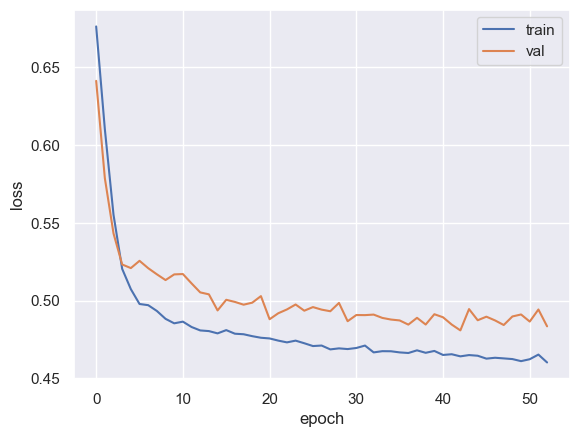

In [8]:
sns.set()
fig, ax = plt.subplots()
trainer.plot_run(exp=exp_name, run=best_context_l, ax=ax)
plt.savefig("../figures/ADNI_c_loss.pdf", bbox_inches="tight")

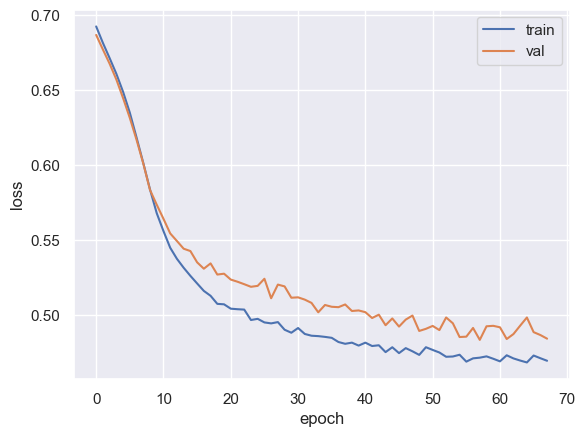

In [9]:
sns.set()
fig, ax = plt.subplots()
trainer.plot_run(exp=exp_name, run="baseline_RNN_64", ax=ax)
plt.savefig("../figures/ADNI_b_loss.pdf", bbox_inches="tight")

## Analyze parameters

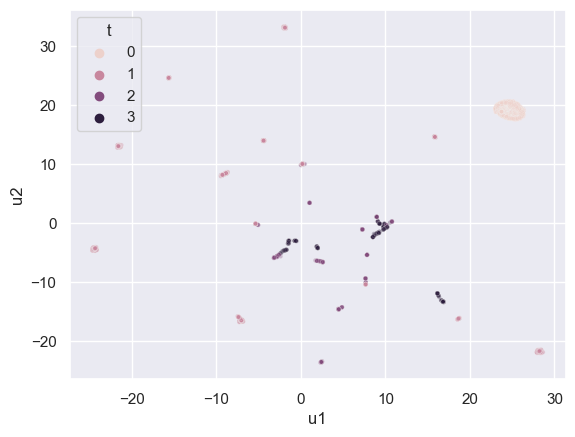

In [10]:
# Map model coefficients to 2D space using UMAP
coef_df, enc = models.map_to_2d(model = model_c, loader_test=loader_all, feature_cols=feature_cols)

fig, ax = plt.subplots()
ax = sns.scatterplot(data=coef_df, x="u1", y="u2", hue="t", alpha=0.3, legend=True, s=10)
ax.set_xlabel("u1")
ax.set_ylabel("u2")
fig.savefig("../figures/ADNI_cluster.pdf", bbox_inches='tight' )

In [11]:
def set_group(df):
    group = None
    if (not df[(df["t"]==0) & (df["CDRSB_med"]==1) & (df["hippocampus_avg"]==1) & (df["a_n"]==1)].empty and 
        not df[(df["t"]==1) & (df["CDRSB_med"]==1) & (df["hippocampus_avg"]==1) & (df["a_n"]==1)].empty):
        group = "Patient A"
    
    elif (not df[(df["t"]==0) & (df["CDRSB_med"]==1) & (df["hippocampus_avg"]==1) & (df["a_n"]==1)].empty and 
          not df[(df["t"]==1) & (df["CDRSB_med"]==1) & (df["hippocampus_low"]==1) & (df["a_n"]==1)].empty):
        group = "Patient B"
    
    elif (not df[(df["t"]==0) & (df["CDRSB_med"]==1) & (df["hippocampus_high"]==1) & (df["a_n"]==1)].empty and 
          not df[(df["t"]==1) & (df["CDRSB_med"]==1) & (df["hippocampus_high"]==1) & (df["a_n"]==1)].empty):
        group = "Patient C"
    
    if group is not None:
        df["group"] = group
        return df
    

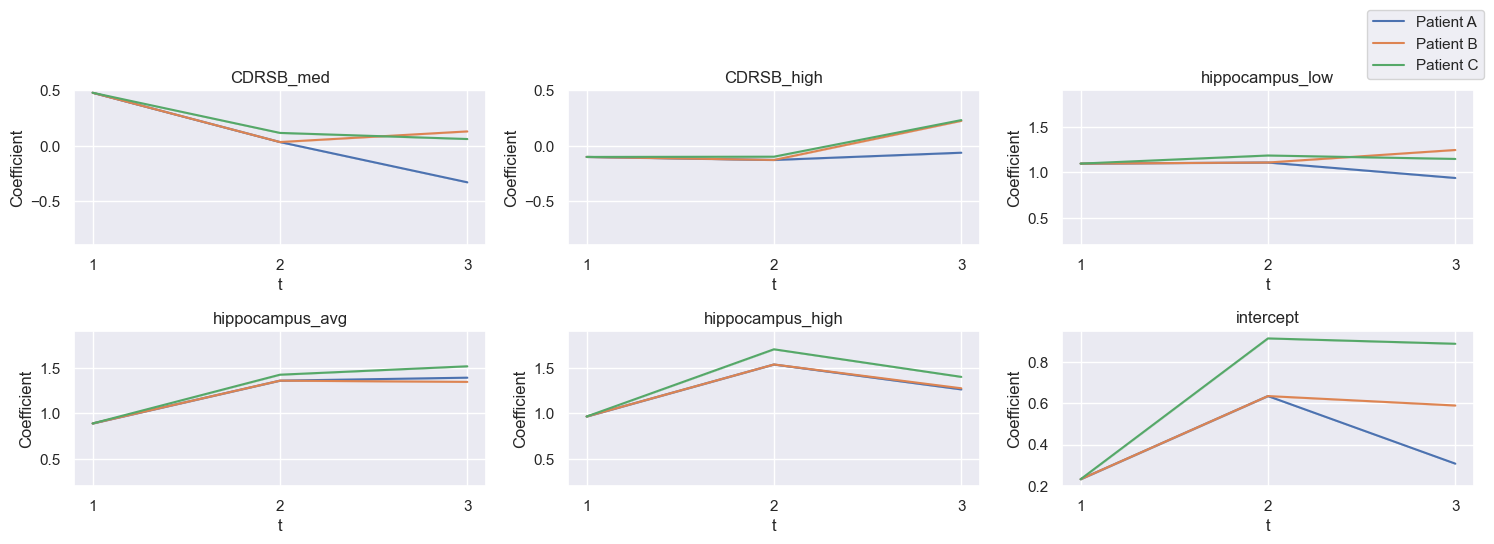

In [12]:
patient_map = full_df.groupby("RID").apply(set_group).reset_index(drop=True)
patient_map.rename(columns={"RID": "id"}, inplace=True)
patient_map = patient_map[["id", "group"]]

relevant_df = pd.merge(coef_df, patient_map, on="id")
relevant_df = relevant_df[relevant_df.t<=2]
relevant_df = relevant_df.rename(columns={"intercept_x": "intercept"})

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,5))
for i, feat in enumerate(feature_cols + ["intercept"]):
    col = i % 3
    row = int(i/3)
    ax_i = ax[row][col]

    relevant_df.sort_values(by=["group", "t"], inplace=True)

    sns.lineplot(data=relevant_df, x="t", y=feat, ax=ax_i, hue="group", errorbar="sd").set(title=f"{feat}")
    ax_i.set_ylabel("Coefficient")
    ax_i.set_xticks(range(3), labels=[1, 2, 3])
    
    if feat == "intercept":
        handles, labels = ax_i.get_legend_handles_labels()
    if "hippocampus" in feat:
        ax_i.set_ylim(0.2, 1.9)
    if "CDRSB" in feat:
        ax_i.set_ylim(-0.9, 0.5)
    ax_i.get_legend().remove()

fig.tight_layout()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.,1.1))
fig.savefig("../figures/ADNI_coefficients_time.pdf", bbox_inches='tight')

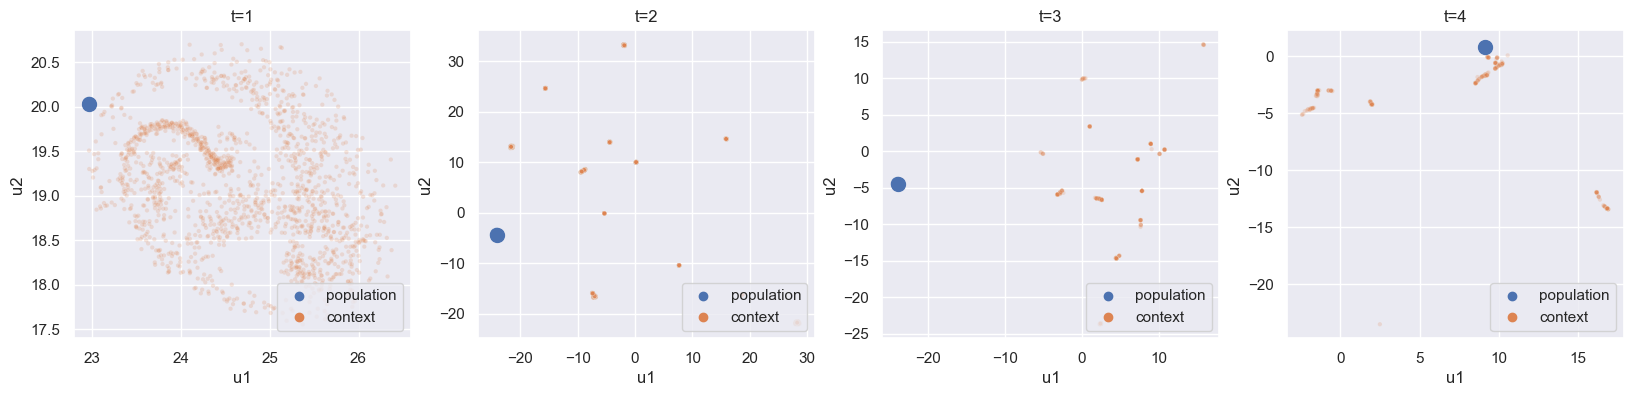

In [13]:
def plot_pop_vs_context(t, reducer, coef_df, pop_models, ax=None, t_col="t", s_context=10):
    pop_reduced = reducer.transform(pop_models[t].reshape(1,-1))
    t_df = pd.DataFrame({"u1": [pop_reduced[0,0]], "u2": [pop_reduced[0,1]], "s":[100], "alpha":[1], "legend":["population"], "hue":["r"]})
    t_context = coef_df[coef_df[t_col]==t].copy()[["u1", "u2"]]
    t_context["s"] = s_context
    t_context["alpha"] = 0.2
    t_context["legend"] = "context"
    t_context["hue"] = "b"
    t_df = pd.concat((t_df, t_context))

    if ax is None:
        fig, ax = plt.subplots()
    else:
        sns.scatterplot(data=t_df, x="u1", y="u2", alpha=t_df.alpha, legend=True, s=t_df.s, hue="legend", ax=ax)
        ax.scatter(pop_reduced[0,0], pop_reduced[0,1], s=100, c="b")
        ax.set_title(f"t={t+1}")
        ax.legend(loc="lower right")

pop_models = {}


for t in range(4):
    train_lr_t = train[train.t==t]
    x_train = train_lr_t[feature_cols].values
    y_train = train_lr_t["a_n"].values

    val_lr_t = val[val.t==t]
    x_val = val_lr_t[feature_cols].values
    y_val = val_lr_t["a_n"].values

    lr_pop = trainer.fit_lr(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, Cs=[1e8, 1e7, 1e6, 1e5, 1000, 100, 10, 1])

    coef = lr_pop.coef_[0]
    intercept = lr_pop.intercept_[0]
    
    pop_models[t] = np.hstack((coef, intercept))

fig, ax = plt.subplots(1,4, figsize=(20,4))

for i in range(4):
    plot_pop_vs_context(reducer=enc, coef_df=coef_df, t=i, pop_models=pop_models, ax=ax[i])

fig.savefig("../figures/ADNI_pop_vs_context.pdf", bbox_inches='tight')

# Subgroup model

In [14]:
df = process_adni()
for t in range(6):
    first_visit = df[df["t"] == t]
    first_visit_groups = first_visit.groupby(["CDRSB", "hippocampus", "a_n"]).size().reset_index().rename(columns={0:f'idx_{t}'})

    n_fv = first_visit_groups.shape[0]
    first_visit_groups[f"idx_{t}"] = list(range(n_fv))
    first_visit_groups[f"idx_{t}"].astype(int)
    first_visit_groups["t"] = t

    df = pd.merge(df, first_visit_groups, left_on=["CDRSB", "hippocampus", "a_n", "t"], right_on=["CDRSB", "hippocampus", "a_n", "t"], how="left")

df = df.fillna(0.5)
# Group visits by context subgroups
cols = [x for x in list(df) if "idx" in x ]
cases = df.groupby(cols).size().reset_index().rename(columns={0:f'idx'})
cases.idx = list(range(cases.shape[0]))

df = pd.merge(df, cases, left_on=cols, right_on=cols)
df = df[["a_n", "CDRSB", "hippocampus", "t", "RID", "idx"]]
df = encode_adni(df)

df = df.sort_values(["RID", "t"])
df['prev_idx'] = df.groupby(["RID"])['idx'].shift()
df["prev_idx"] = df["prev_idx"].fillna(df["prev_idx"].max()+1)

/Users/jannik/Documents/CMU/Thesis/final/Thesis/src/preprocess/adni.py:22: DtypeWarning: Columns (19,20,21,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  tab = pd.read_csv(RAW_PATH / f"{filename}.csv")


In [15]:
# Select train, val, test

train_bf = df[(df.RID.isin(train.RID))]
val_bf = df[(df.RID.isin(val.RID))]
test_bf = df[(df.RID.isin(test.RID))]

# Train subgroup models
m = train["a_n"].mean()
preds = []
trues = []
test_dfs = []

for idx in range(int(df["prev_idx"].max()) + 1):
    train_i = train_bf[train_bf["prev_idx"]==idx]
    val_i = val_bf[val_bf["prev_idx"]==idx]
    test_i = test_bf[test_bf["prev_idx"]==idx].copy()

    if test_i.shape[0] == 0:
        pass
    # exclude groups with no test data
    else:
        x_te_i = test_i[feature_cols].values
        y_te_i = test_i[target_col].values

        # In this case we can train a model
        if train_i.shape[0] > 0 and val_i.shape[0] > 0:
            x_t_i = train_i[feature_cols].values
            y_t_i = train_i[target_col].values
            x_v_i = val_i[feature_cols].values
            y_v_i = val_i[target_col].values
            if len(np.unique(train_i[target_col].values)) == 2:
                model = trainer.fit_lr(x_train=x_t_i, y_train=y_t_i, x_val=x_v_i, y_val=y_v_i, maxiter=500000)
                y_te_hat = model.predict_proba(x_te_i)[:,1]
            else:
                y_te_hat = np.repeat(np.mean(y_t_i), y_te_i.shape[0])

        # In this case we can't train a model, so we use the mean of the training data
        else:
            y_te_hat = np.repeat(m, test_i.shape[0])
        
        preds.append(y_te_hat)
        trues.append(y_te_i)

        test_i["preds_lr"] = y_te_hat
        test_dfs.append(test_i)

test_df = pd.concat(test_dfs)

pred = np.concatenate(preds)
gt = np.concatenate(trues)
print(f"AUROC subgroup: {roc_auc_score(gt, pred):.2f}")

/opt/homebrew/Caskroom/miniconda/base/envs/cpr/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


AUROC subgroup: 0.71


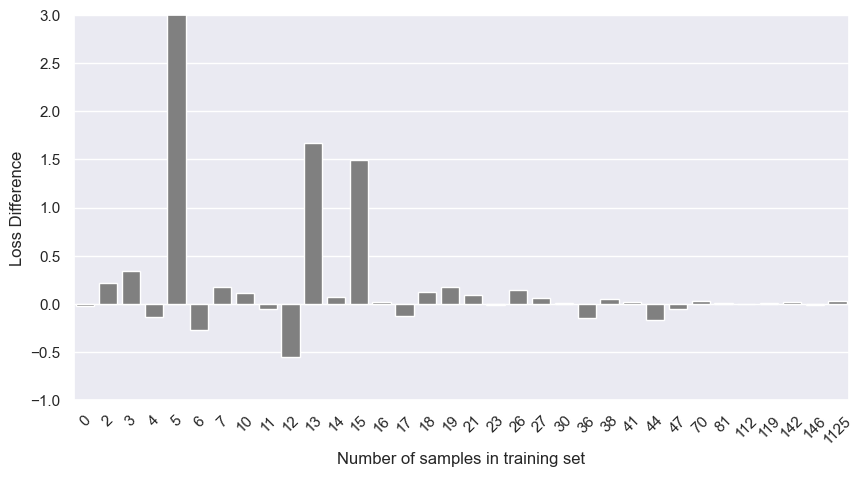

In [16]:
df_lr_c = pd.merge(coef_df[["id", "t", "prob"]], test_df, left_on=["id", "t"], right_on=["RID", "t"])
df_lr_c["logloss_c"] = log_loss(df_lr_c["a_n"], df_lr_c["prob"])
df_lr_c["logloss_lr"] = log_loss(df_lr_c["a_n"], df_lr_c["preds_lr"])

ll_df = pd.DataFrame(columns=["logloss_c", "logloss_lr", "val", "count_test"])

for val in df_lr_c.prev_idx.unique():
    df_v = df_lr_c[df_lr_c.prev_idx==val].copy()
    size = df_v.shape[0]
    logloss_c = log_loss(df_v["a_n"], df_v["prob"], labels=[0,1])
    logloss_lr = log_loss(df_v["a_n"], df_v["preds_lr"], labels=[0,1])

    ll_df = pd.concat([ll_df, pd.DataFrame({"logloss_c": [logloss_c], "logloss_lr": [logloss_lr], "val": [val], "count_test":[size]})])

train_count = train_bf.groupby(["prev_idx"]).size().reset_index().rename(columns={0:f'Number of samples in training set'})
df_merged = pd.merge(ll_df, train_count, left_on="val", right_on="prev_idx", how="left").drop(columns=["prev_idx"]).fillna(0)
df_merged["Loss Difference"] = df_merged["logloss_lr"] - df_merged["logloss_c"]

fig, ax = plt.subplots(figsize=(10, 5))
df_merged_grp = df_merged[["Number of samples in training set", "Loss Difference"]].groupby(["Number of samples in training set"]).mean().reset_index()
df_merged_grp["Number of samples in training set"] = df_merged_grp["Number of samples in training set"].round(0).astype(int)
sns.barplot(x="Number of samples in training set", y="Loss Difference", data=df_merged_grp, ax=ax, color="grey")

#rotate xticks
for item in ax.get_xticklabels():
    item.set_rotation(45)
ax.set_ylim(-1, 3)

fig.savefig(f"../figures/ADNI_loss_diff_lr.pdf", bbox_inches='tight')

## Static context

In [17]:
df = process_adni()
df = encode_adni(df)

gender_map = {"Male":0, "Female":1}
df["gender"] = df["gender"].map(gender_map)

train_a = df[df.RID.isin(train_r.RID)]
val_a = df[df.RID.isin(val_r.RID)]
test_a = df[df.RID.isin(test_r.RID)]

max_length = df.t.max() + 1

/Users/jannik/Documents/CMU/Thesis/final/Thesis/src/preprocess/adni.py:22: DtypeWarning: Columns (19,20,21,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  tab = pd.read_csv(RAW_PATH / f"{filename}.csv")


In [18]:
ds_train_a = data.Context_df_dataset(train_a, feature_cols=feature_cols, target_col="a_n", identifier_col="RID",
                                    max_length=max_length, static_cols=["age", "gender"])
ds_val_a = data.Context_df_dataset(val_a, feature_cols=feature_cols, target_col="a_n", identifier_col="RID",
                                 max_length=max_length, static_cols=["age", "gender"])
ds_test_a = data.Context_df_dataset(test_a, feature_cols=feature_cols, target_col="a_n", identifier_col="RID",
                                    max_length=max_length, static_cols=["age", "gender"]) 

loader_train_a = DataLoader(ds_train_a, shuffle=True, batch_size=64)
loader_val_a = DataLoader(ds_val_a, shuffle=True, batch_size=64)
loader_test_a = DataLoader(ds_test_a, shuffle=False, batch_size=1)

full_df = pd.concat([train_a, val_a, test_a])
ds_full_a = data.Context_df_dataset(full_df, feature_cols=feature_cols, target_col="a_n", identifier_col="RID", max_length=max_length, static_cols=["age", "gender"])
loader_full_a = DataLoader(ds_full_a, shuffle=False, batch_size=1)

In [23]:
exp_name = "ADNI_age_gender"

trainer.train_contextual(exp_name=exp_name, context_size=7, input_size=6, train_loader=loader_train_a, 
                         val_loader=loader_val_a, lr=5e-4, lambdas=[0.1, 0.01, 0.001, 0.0001])

best_context_l_static = trainer.get_best_run(exp=exp_name, pref="context_LSTM")
model_static = trainer.load_run(best_context_l_static, dataset_name=exp_name)
pred_context_a, true_context_a = models.model_predict(model_static, loader_test_a)

print(f"AUROC static context {roc_auc_score(true_context_a, pred_context_a):.3f}")

Run context_LSTM_16_0.1 already exists, skipping.
Run context_LSTM_16_0.01 already exists, skipping.
Run context_LSTM_16_0.001 already exists, skipping.
Run context_LSTM_16_0.0001 already exists, skipping.
Run context_LSTM_32_0.1 already exists, skipping.
Run context_LSTM_32_0.01 already exists, skipping.
Run context_LSTM_32_0.001 already exists, skipping.
Run context_LSTM_32_0.0001 already exists, skipping.
Run context_LSTM_64_0.1 already exists, skipping.
Run context_LSTM_64_0.01 already exists, skipping.
Run context_LSTM_64_0.001 already exists, skipping.
Run context_LSTM_64_0.0001 already exists, skipping.
AUROC static context 0.763


In [20]:
group_A = relevant_df[relevant_df["group"]=="Patient A"].id.unique()
group_B = relevant_df[relevant_df["group"]=="Patient B"].id.unique()
group_C = relevant_df[relevant_df["group"]=="Patient C"].id.unique()

colors = {"A": {"Patient A o70": "blue", "Patient A u70": "deepskyblue"}, 
          "B": {"Patient B o70": "red", "Patient B u70": "darkorange"},
          "C": {"Patient C o70": "green", "Patient C u70": "limegreen"}}

coef_df, reducer = models.map_to_2d(model = model_static, loader_test=loader_full_a, feature_cols=feature_cols)
df_g = pd.merge(coef_df, full_df[["RID", "t", "age", "gender"]], left_on=["id", "t"], right_on=["RID", "t"], how="inner")
df_g["age_group"] = df_g["age"].apply(lambda x: int(x/10))

def get_patient_group(id, pref):
    l_g = df_g[df_g.id.isin(id)]
    l_g["old"] = df_g["age"].apply(lambda x: f"Patient {pref} o70" if x>70 else f"Patient {pref} u70")

    test = l_g.groupby(["t", "old"]).mean()[feature_cols + ["intercept"]].reset_index()
    #test["color"] = test["old"].apply(lambda x: colors[pref]["o"] if x==f"Patient {pref} o70" else colors[pref]["u"])
    test = test[test.t < 3]
    return test

la = get_patient_group(group_A, pref="A")
lb = get_patient_group(group_B, pref="B")
lc = get_patient_group(group_C, pref="C")

/var/folders/gh/d90ndmrs5cnbgp4smtcmckjc0000gn/T/ipykernel_94607/1140374470.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l_g["old"] = df_g["age"].apply(lambda x: f"Patient {pref} o70" if x>70 else f"Patient {pref} u70")
/var/folders/gh/d90ndmrs5cnbgp4smtcmckjc0000gn/T/ipykernel_94607/1140374470.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l_g["old"] = df_g["age"].apply(lambda x: f"Patient {pref} o70" if x>70 else f"Patient {pref} u70")
/var/folders/gh/d90ndmrs5cnbgp4smtcmckjc0000gn/T/ipykern

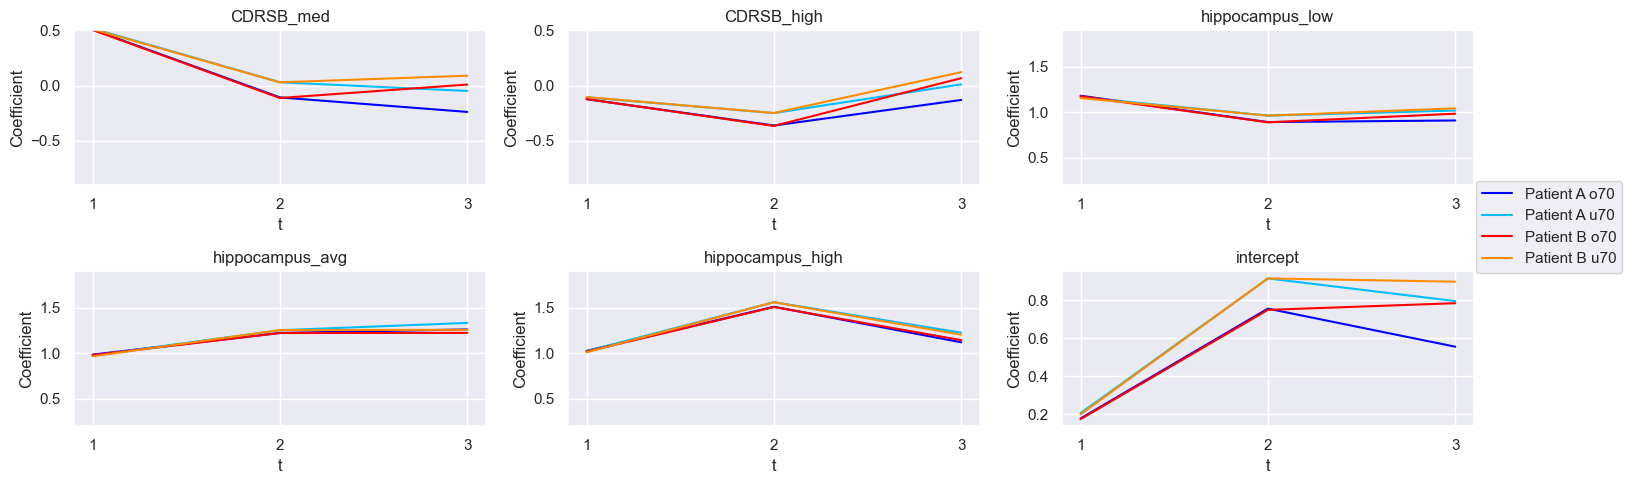

In [21]:
#fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(20, 3))
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 5))

sns.set()

for i, feat in enumerate(feature_cols + ["intercept"]):
    col = i % 3
    row = int(i/3)
    ax_i = ax[row][col]

    sns.lineplot(data=la, x="t", y=feat, ax=ax_i, hue="old", errorbar="sd",palette=colors["A"]).set(title=f"{feat}")
    ax_i.set_ylabel("Coefficient")
    
    ax_i.set_xticks(range(3), labels=[1, 2, 3])
    
    if "hippocampus" in feat:
        ax_i.set_ylim(0.2, 1.9)
    
    if "CDRSB" in feat:
        ax_i.set_ylim(-0.9, 0.5)
    
    #ax_i.get_legend().remove()

for i, feat in enumerate(feature_cols + ["intercept"]):
    col = i % 3
    row = int(i/3)
    ax_i = ax[row][col]

    sns.lineplot(data=lb, x="t", y=feat, ax=ax_i, hue="old", errorbar="sd",palette=colors["B"]).set(title=f"{feat}")
    ax_i.set_ylabel("Coefficient")
    
    ax_i.set_xticks(range(3), labels=[1, 2, 3])

    if feat == "intercept":

        handles, labels = ax_i.get_legend_handles_labels() 
    
    if "hippocampus" in feat:
        ax_i.set_ylim(0.2, 1.9)
    
    if "CDRSB" in feat:
        ax_i.set_ylim(-0.9, 0.5)
    
    ax_i.get_legend().remove()

fig.tight_layout()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.092,0.53))

fig.savefig("../figures/ADNI_coef_age_gender.pdf", bbox_inches="tight")

/var/folders/gh/d90ndmrs5cnbgp4smtcmckjc0000gn/T/ipykernel_94607/3914512271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l0["old"] = l0["age"].apply(lambda x: "o70" if x>70 else "u70")
/var/folders/gh/d90ndmrs5cnbgp4smtcmckjc0000gn/T/ipykernel_94607/3914512271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l0["gender_l"] = l0["gender"].apply(lambda x: "M" if x==0 else "F")
/var/folders/gh/d90ndmrs5cnbgp4smtcmckjc0000gn/T/ipykernel_94607/3914512271.py:4: SettingWithCopyWarning: 
A value is trying

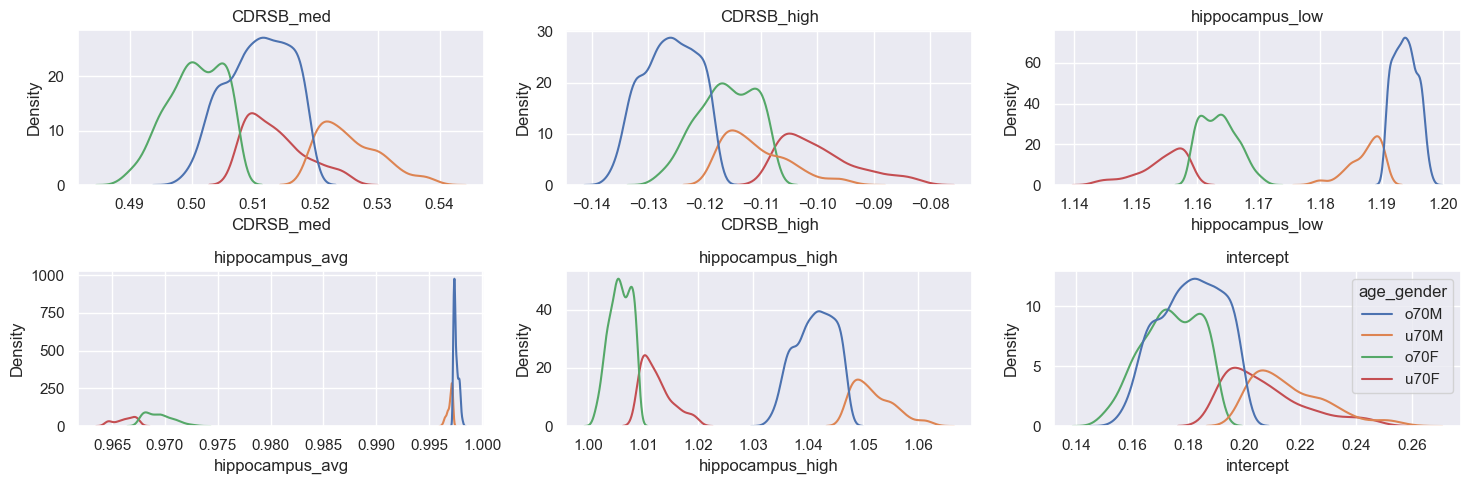

In [22]:
l0 = df_g[df_g.t==0]
l0["old"] = l0["age"].apply(lambda x: "o70" if x>70 else "u70")
l0["gender_l"] = l0["gender"].apply(lambda x: "M" if x==0 else "F")
l0["age_gender"] = l0["old"] + l0["gender_l"]


legend_labels = ["o70M", "o70F", "u70M", "u70F"] 
fig, axi = plt.subplots(ncols=3, nrows=2, figsize=(15, 5))

sns.set()

handles, labels = None, None

for i, feat in enumerate(feature_cols + ["intercept"]):
    col = i % 3
    row = int(i/3)
    ax_i = axi[row][col]


    sns.kdeplot(l0, x=feat, ax=ax_i, hue="age_gender", legend=True).set(title=f"{feat}")

    if feat == "intercept":
        pass
        #ax_i.legend(bbox_to_anchor=(1.02, 1), loc='upper right', borderaxespad=0)


    else:
        ax_i.get_legend().remove()

fig.tight_layout()
fig.savefig("../figures/ADNI_coef_age_gender_t0.pdf", bbox_inches="tight")